In [61]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import json
import h5py
from scipy import ndimage

from infer_sociohydro2D import *

# Test on simulation data

In [2]:
parent_folder = "/Users/danny/Library/CloudStorage/GoogleDrive-dsseara@uchicago.edu/My Drive/uchicago/sociohydro"

# fipy solver data
datafolder = "2024-06-19_schelling2D2S_fipy"

folder = os.path.join(parent_folder, datafolder)

datafile = glob(os.path.join(folder, "*hdf5"))[0]
paramfile = glob(os.path.join(folder, "*json"))[0]

with open(paramfile, "r") as p:
    params = json.load(p)

with h5py.File(datafile, "r") as d:
    xx = np.unique(d["common"]["x"][()])
    yy = np.unique(d["common"]["y"][()])
    ϕ1 = np.zeros((params["nt"]+1, params["nx"], params["ny"]))
    ϕ2 = np.zeros((params["nt"]+1, params["nx"], params["ny"]))
    tt = np.zeros(params["nt"]+1)
    for kidx, key in enumerate(list(d.keys())[1:]):
        ϕ1[kidx] = np.reshape(d[key]["phi1"][()], (params["nx"], params["ny"]))
        ϕ2[kidx] = np.reshape(d[key]["phi2"][()], (params["nx"], params["ny"]))
        tt[kidx] = d[key]["t"][()]

nonzero_idx = np.where(ϕ1[:, 0, 0])[0]
ϕ1 = ϕ1[nonzero_idx]
ϕ2 = ϕ2[nonzero_idx]
tt = tt[nonzero_idx]

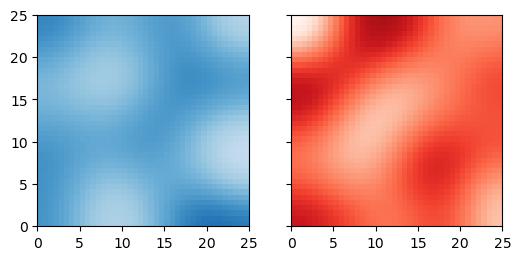

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
ax[0].pcolormesh(xx, yy, ϕ1[-1], cmap="Blues", vmin=0.1, vmax=0.4)
ax[0].set_aspect(1)
ax[1].pcolormesh(xx, yy, ϕ2[-1], cmap="Reds", vmin=0.1, vmax=0.4)
ax[1].set_aspect(1)



In [42]:
inferer = SociohydroInfer2D(ϕ1[100:-1], ϕ2[100:-1], xx, yy, tt[100:-1])

In [43]:
T = params["temp"]
Γ = params["gamma"]
k11 = 1
k22 = 1
k12 = params["kp"] - params["km"]
k21 = params["kp"] + params["km"]
nu = params["nu"]

coeffsA_true = np.array([T, -k11, -k12, -Γ, 0,        0, 0])
coeffsB_true = np.array([T, -k22, -k21, -Γ, k22 * nu, 0, 0])

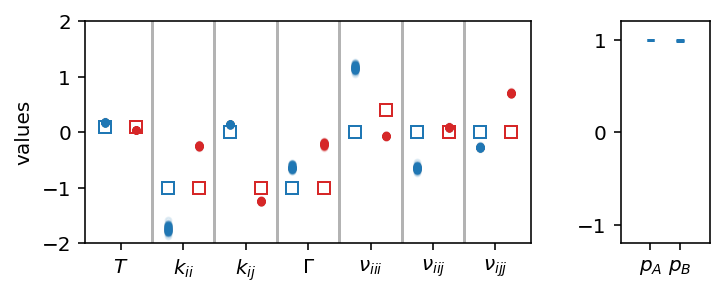

In [47]:
train_pct = 0.5
fig, ax = plt.subplots(dpi=144, figsize=(4, 2))
axp = ax.inset_axes([1.2, 0, 0.2, 1])
pAs = []
pBs = []
for i in range(100):
    fitA, fitB, pA, pB = inferer.fit(train_pct)
    ax.plot(np.arange(len(fitA.coef_)) - 0.25, fitA.coef_, "C0.", alpha=0.1)
    ax.plot(np.arange(len(fitB.coef_)) + 0.25, fitB.coef_, "C3.", alpha=0.1)
    pAs.append(pA)
    pBs.append(pB)
    # axp.plot([0, 1], [pA, pB], 'k.', alpha=0.1)

ax.plot(np.arange(len(fitA.coef_)) - 0.25, coeffsA_true, "s", mfc="white", mec="C0", zorder=-1)
ax.plot(np.arange(len(fitB.coef_)) + 0.25, coeffsB_true, "s", mfc="white", mec="C3", zorder=-1)

axp.violinplot([pAs, pBs], [0, 1])
axp.set(yticks=[-1, 0, 1], xticks=[0, 1],
        xticklabels=[r"$p_A$", r"$p_B$"])

for n in range(1, len(fitA.coef_)):
    ax.axvline(n - 0.5, color="0.7")

ax.set(xticks=range(len(fitA.coef_)),
       ylim=[-2, 2],
       xticklabels=[r"$T$", r"$k_{ii}$", r"$k_{ij}$", r"$\Gamma$",
                    r"$\nu_{iii}$", r"$\nu_{iij}$", r"$\nu_{ijj}$"],
       ylabel="values")
axp.set(xlim=[-1, 2], ylim=[-1.2, 1.2]);
# axp.set_yticks([-1, 0, 1], loc="right")

# Test on Census data

In [50]:
def get_data(file, year=1990, region="all"):
    ykey = str(year)
    with h5py.File(file, "r") as d:
        x_grid = d[ykey]["x_grid"][()]
        y_grid = d[ykey]["y_grid"][()]
        capacity = np.zeros(x_grid.shape)
        if region == "county":
            white = d[ykey]["white_grid_county"][()]
            black = d[ykey]["black_grid_county"][()]
            for key in d.keys():
                capacity = np.fmax(capacity, d[key]["white_grid_county"][:] + d[key]["black_grid_county"][:])
        elif region == "all":
            white = d[ykey]["white_grid_masked"][()]
            black = d[ykey]["black_grid_masked"][()]
            for key in d.keys():
                capacity = np.fmax(capacity, d[key]["white_grid_masked"][:] + d[key]["black_grid_masked"][:])

    ϕW = white / (1.1 * capacity)
    ϕB = black / (1.1 * capacity)

    return ϕW, ϕB, x_grid, y_grid

In [86]:
datafolder = "/Users/danny/code/uchicago/sociohydro/data/raw/gridded/Illinois_Cook.hdf5"
years = [1980, 1990, 2000, 2010, 2020]

ϕW = []
ϕB = []
for year in years:
    w, b, xx, yy = get_data(datafolder, year=year, region="all")
    ϕW.append(w)
    ϕB.append(b)

ϕW = np.asarray(ϕW)
ϕB = np.asarray(ϕB)
xx /= 1000
yy /= 1000

# smooth
ϕW_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕW), 0.5, axes=[1, 2])
ϕW_smooth[np.isnan(ϕW)] = np.nan
ϕB_smooth = ndimage.gaussian_filter(np.nan_to_num(ϕB), 0.5, axes=[1, 2])
ϕB_smooth[np.isnan(ϕB)] = np.nan

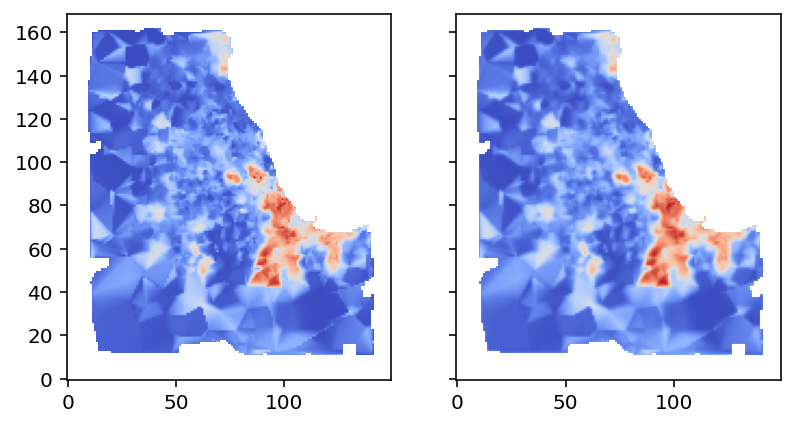

In [87]:
fig, ax = plt.subplots(1, 2, dpi=144, sharey=True)
ax[0].imshow((ϕW - ϕB)[-1], origin="lower", cmap="coolwarm_r")
ax[1].imshow((ϕW_smooth - ϕB_smooth)[-1], origin='lower', cmap="coolwarm_r")

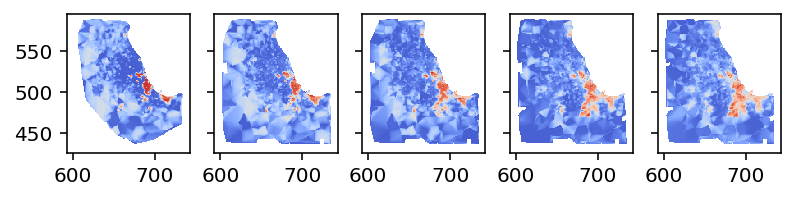

In [60]:
fig, ax = plt.subplots(1, len(years), dpi=144, sharey=True)
for idx in range(len(years)):
    ax[idx].pcolormesh(xx, yy, ϕW[idx] - ϕB[idx],
                       cmap="coolwarm_r", vmin=-1, vmax=1)
    ax[idx].set_aspect(1)